## Задача банковского скоринга

### Данные:

Датасет разделен на две части: тренировочную (banking_training.csv) и тестовую (banking_test.csv). Используя banking_training.csv происходит тренировка алгоритма, предсказание осуществляется на banking_test.csv.

Описание фичей данных находится в файле banking_desc.csv


### Задача:

Бинарная вероятностная классификация.

Ваша задача спрогнозировать возниконение трудностей у кредитора в течение двух лет (переменная SeriousDlqin2yrs, принимающая значения [0,1]). Также необходимо спрогнозировать вероятность для данной переменной SeriousDlqin2yrs.

Алгоритм для выполнения задачи можно выбирать любой. Кросс-валидация должна выполняться методом KFold с n_folds=10

### Ход работы:

1. Провести первичный анализ данных: описательные статистики, распределения, наличия пропущенных значений.

2. Осуществить препроцессинг и подготовку данных: выбрать стратегию работы с пропущенными значениями (обьяснить свой выбор), осуществить генерацию дополнительных фичей (обьяснить логику). 

3. Провести корреляционный анализ и проверить выбор дополнительных фичей в сете.

4. Отобрать фичи для построения модели используя подход Variance Threshold. Обьяснить принцип работы.

5. Отобрать фичи для построения модели используя любой из методов Univariate Feature Selection (к примеру SelectKBest или SelectPercentile). Обьяснить принцип работы.

6. Отобрать фичи для построения модели используя на выбор либо L1-регрессию (Lasso) либо подход основанный на использовании деревьев (Tree-based). Обьяснить принцип работы.

7. Протестировать на тренировочном дата сете различные наборы фичей и их работу с выбранными алгоритмами для осуществления предсказания.

8. Выбрать лучший набор фичей и лучший алгоритм для осуществленния как предсказания классов так и вероятности. Провести сравнение на тестовой выборке используя следующие метрики для оценки качества алгоритма: 

    -Классификация: Accuracy Score, f1-Score, Precision, Recall
    
    -Вероятность: log_loss Score    
    
9. Задания принимаются в виде ноутбука с полным кодом работы.

подключаем библиотеки

In [262]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold

from sklearn.linear_model import LogisticRegression as log_reg, LinearRegression as lr_reg
from sklearn.ensemble import RandomForestClassifier as rf, RandomForestRegressor as rf_reg
from sklearn.ensemble import GradientBoostingClassifier as gb, GradientBoostingRegressor as gb_reg

import sklearn.cluster as cluster

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss

import time
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")

In [103]:
!ls

FE_LAB_BANKING.ipynb banking_test.csv
banking_desc.xls     banking_training.csv


In [105]:
#!open .

In [106]:
desc = pd.read_excel('banking_desc.xls')

In [107]:
train = pd.read_csv('banking_training.csv')

In [108]:
test = pd.read_csv('banking_test.csv')

# 1. Провести первичный анализ данных: описательные статистики, распределения, наличия пропущенных значений.

In [109]:
desc

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquenc...,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lin...,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days p...,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs di...",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loa...,integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or m...,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans inclu...,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days p...,integer


In [110]:
train.head(20)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


посмотрим количество ссуд

In [111]:
#train.NumberOfOpenCreditLinesAndLoans.value_counts()

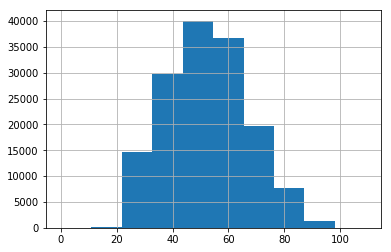

In [112]:
train.age.hist()

In [113]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
Unnamed: 0                              150000 non-null int64
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(8)
memory usage: 13.7 MB


# Фичи

чтобы одинаковым образом обработать train и test и не дублировать все операции 2 раза, соединим эти два набора данных в один, не забыв при этом:
1. выкинуть целевую переменную из train и test
2. проверить на соответствие набора признаков друг другу
3. добавить флаг того, является ли объект тестовым или нет

In [114]:
y_train = train.SeriousDlqin2yrs
train.drop('SeriousDlqin2yrs', axis=1, inplace=True)
test.drop('SeriousDlqin2yrs', axis=1, inplace=True)

In [115]:
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [116]:
train['is_test'] = 0
test['is_test'] = 1

In [117]:
df = pd.concat([train, test])

In [118]:
df.describe()

,Unnamed: 0,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,is_test
count,251503.000000,251503.000000,251503.000000,251503.000000,251503.000000,2.016690e+05,251503.000000,251503.000000,251503.000000,251503.000000,244953.000000,251503.000000
mean,65214.153533,5.750415,52.339694,0.434245,349.562468,6.744818e+03,8.453064,0.278370,1.016155,0.252466,0.761995,0.403586
std,40078.948539,229.633980,14.775120,4.335643,1884.792016,2.571761e+04,5.145194,4.312539,1.121935,4.299204,1.123905,0.490617
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31438.500000,0.029977,41.000000,0.000000,0.174330,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62876.000000,0.153575,52.000000,0.000000,0.365612,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,94314.000000,0.561293,63.000000,0.000000,0.861754,8.212000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,1.000000
max,150000.000000,50708.000000,109.000000,98.000000,329664.000000,7.727000e+06,85.000000,98.000000,54.000000,98.000000,43.000000,1.000000


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251503 entries, 0 to 101502
Data columns (total 12 columns):
Unnamed: 0                              251503 non-null int64
RevolvingUtilizationOfUnsecuredLines    251503 non-null float64
age                                     251503 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    251503 non-null int64
DebtRatio                               251503 non-null float64
MonthlyIncome                           201669 non-null float64
NumberOfOpenCreditLinesAndLoans         251503 non-null int64
NumberOfTimes90DaysLate                 251503 non-null int64
NumberRealEstateLoansOrLines            251503 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    251503 non-null int64
NumberOfDependents                      244953 non-null float64
is_test                                 251503 non-null int64
dtypes: float64(4), int64(8)
memory usage: 24.9 MB


# 2. Осуществить препроцессинг и подготовку данных: выбрать стратегию работы с пропущенными значениями (обьяснить свой выбор), осуществить генерацию дополнительных фичей (обьяснить логику). 

у нас нет данных по месячном доходу примерно у 10 процентов 

и чуток не хватает данных по количеству человек в семье

заполним пустые значения средними по соответственным признакам. Если модель покажет плохой результат - месячный догод спрогнозируем регрессией а количество человек будем брать как среднее по возрасту.

In [120]:
NumberOfDependents_median = df['NumberOfDependents'].median()
MonthlyIncome_median = df['MonthlyIncome'].median()
df['NumberOfDependents'].fillna( NumberOfDependents_median, inplace = True )
df['MonthlyIncome'].fillna( MonthlyIncome_median, inplace = True )

In [121]:
df.isnull().values.any()

False

# 3. Провести корреляционный анализ и проверить выбор дополнительных фичей в сете.

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

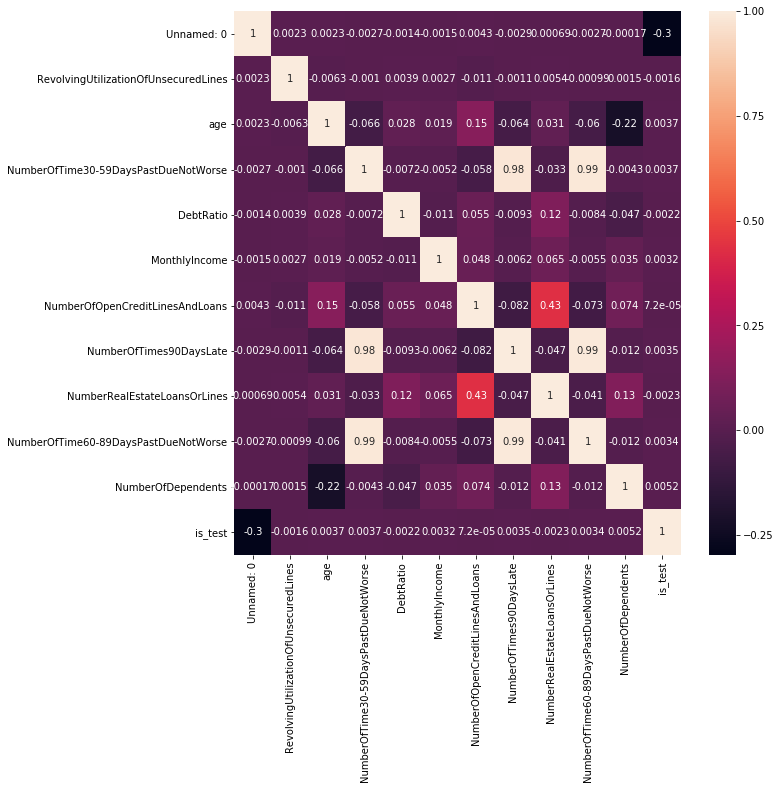

In [131]:
corr = df.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)




сделаем из возраста несколько категорий: 
юноши: до 21 года,
взрослый: 21 — 60 лет,
пожилой возраст: 60 — 75 лет,
долгожители — 75 лет и более

In [171]:
def set_age_category(age):
    if(age < 21):
        return 1
    elif(age < 60):
        return 2
    elif(age < 75):
        return 3
    else:
        return 4

In [172]:
df['age_category'] = df['age'].apply(set_age_category)

In [174]:
df.drop('age', axis=1, inplace=True)

закодируем возраст в отдельные столбцы

In [175]:
df_dummies = pd.get_dummies(df, columns=['age_category'])

In [183]:
df_dummies.head()

,Unnamed: 0,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,is_test,age_category_1,age_category_2,age_category_3,age_category_4
0,1,0.766127,2,0.802982,9120.0,13,0,6,0,2.0,0,0,1,0,0
1,2,0.957151,0,0.121876,2600.0,4,0,0,0,1.0,0,0,1,0,0
2,3,0.658180,1,0.085113,3042.0,2,1,0,0,0.0,0,0,1,0,0
3,4,0.233810,0,0.036050,3300.0,5,0,0,0,0.0,0,0,1,0,0
4,5,0.907239,1,0.024926,63588.0,7,0,1,0,0.0,0,0,1,0,0


In [226]:
X_train = df_dummies[df_dummies.is_test==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies.is_test==1].drop('is_test', axis=1)

# 4 Отобрать фичи для построения модели используя подход Variance Threshold. Обьяснить принцип работы.

In [227]:
from sklearn.feature_selection import VarianceThreshold

In [228]:
selector = VarianceThreshold(threshold=0.1)
fature_set = selector.fit_transform(X_train,y_train)

mask = selector.get_support()
list(X_train.columns[mask])

['Unnamed: 0',
 'RevolvingUtilizationOfUnsecuredLines',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents',
 'age_category_2',
 'age_category_3']

VarianceThreshold - это селектор фичей, который удаляет все фичи с низкой дисперсией.

Этот алгоритм выбора функции смотрит только на функции X_train, но не на y

In [229]:
X_train.columns[mask]

Index(['Unnamed: 0', 'RevolvingUtilizationOfUnsecuredLines',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'age_category_2', 'age_category_3'],
      dtype='object')

In [230]:
X_train_VarianceThreshold = pd.DataFrame(X_train, columns=list(X_train.columns[mask]))

In [231]:
X_train_VarianceThreshold.head()

,Unnamed: 0,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_category_2,age_category_3
0,1,0.766127,2,0.802982,9120.0,13,0,6,0,2.0,1,0
1,2,0.957151,0,0.121876,2600.0,4,0,0,0,1.0,1,0
2,3,0.658180,1,0.085113,3042.0,2,1,0,0,0.0,1,0
3,4,0.233810,0,0.036050,3300.0,5,0,0,0,0.0,1,0
4,5,0.907239,1,0.024926,63588.0,7,0,1,0,0.0,1,0


# 5. Отобрать фичи для построения модели используя любой из методов Univariate Feature Selection (к примеру SelectKBest или SelectPercentile). Обьяснить принцип работы.

In [235]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
selector = SelectKBest(chi2, k=8)
selector.fit(X_train, y_train)

SelectKBest(k=8, score_func=<function chi2 at 0x119ad8840>)

In [236]:
X_train.shape

(150000, 14)

In [239]:
X_train_SelectKBest = SelectKBest(chi2, k=8).fit_transform(X_train, y_train)
X_train_SelectKBest.shape

(150000, 8)


метод выбирает указанное количество фич с наивысшими баллами, которые есть результатами  одномерных статистических тестов.

# 6. Отобрать фичи для построения модели используя на выбор либо L1-регрессию (Lasso) либо подход основанный на использовании деревьев (Tree-based). Обьяснить принцип работы.

In [245]:
from sklearn.linear_model import Lasso

In [246]:
rg = Lasso().fit(X_train, y_train)
print(rg.intercept_)
print(rg.coef_)

0.06802332096236387
[ 1.57555838e-08 -0.00000000e+00  0.00000000e+00 -7.27311159e-07
 -3.28467384e-07 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00]


In [247]:
X_train_lasso = StandardScaler().fit_transform(X_train)


# 7. Протестировать на тренировочном дата сете различные наборы фичей и их работу с выбранными алгоритмами для осуществления предсказания.

Создадим функцию cv() в которой будет осуществляться процесс кросс-валидации. Используем подход KFold с n_folds=10

In [208]:
def cv(X,y,clf_class):
    
    kf = KFold(len(y),n_folds=10,shuffle=False)
    y_pred = y.copy()

    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf = clf_class()
        clf.fit(X_train,y_train)

        y_pred[test_index] = clf.predict(X_test)
        
    return y_pred

In [233]:
X_train_VarianceThreshold = StandardScaler().fit_transform(X_train_VarianceThreshold)

In [234]:
print("VarianceThreshold scores:")
print(accuracy_score(y,cv(X_train_VarianceThreshold,Y_train,log_reg)))
print(f1_score(y,cv(X_train_VarianceThreshold,Y_train,log_reg),average='weighted'))
print(precision_score(y,cv(X_train_VarianceThreshold,Y_train,log_reg),average='weighted'))
print(recall_score(y,cv(X_train_VarianceThreshold,Y_train,log_reg),average='weighted'))

VarianceThreshold scores:
0.9339
0.9063477369394762
0.9116519014953791
0.9339


In [240]:
print("X_train_SelectKBest scores:")
print(accuracy_score(y,cv(X_train_SelectKBest,Y_train,log_reg)))
print(f1_score(y,cv(X_train_SelectKBest,Y_train,log_reg),average='weighted'))
print(precision_score(y,cv(X_train_SelectKBest,Y_train,log_reg),average='weighted'))
print(recall_score(y,cv(X_train_SelectKBest,Y_train,log_reg),average='weighted'))

X_train_SelectKBest scores:
0.9331733333333333
0.9014224865662365
0.9052810302793349
0.9331733333333333


In [248]:
print("X_train_lasso scores:")
print(accuracy_score(y,cv(X_train_lasso,Y_train,log_reg)))
print(f1_score(y,cv(X_train_lasso,Y_train,log_reg),average='weighted'))
print(precision_score(y,cv(X_train_lasso,Y_train,log_reg),average='weighted'))
print(recall_score(y,cv(X_train_lasso,Y_train,log_reg),average='weighted'))

X_train_lasso scores:
0.9338866666666666
0.9063288459131401
0.9115529458047162
0.9338866666666666


In [257]:
max([0.9339, 0.9331733333333333, 0.9338866666666666])

0.9339

In [258]:
max([0.9063477369394762, 0.9014224865662365, 0.9063288459131401])

0.9063477369394762

In [259]:
max([0.9116519014953791, 0.9052810302793349, 0.9115529458047162])

0.9116519014953791

In [260]:
max([0.9339, 0.9331733333333333, 0.9338866666666666])

0.9339

Будем импользовать VarianceThreshold датасет

# 8. Выбрать лучший набор фичей и лучший алгоритм для осуществленния как предсказания классов так и вероятности. Провести сравнение на тестовой выборке используя следующие метрики для оценки качества алгоритма: 

In [263]:
print(accuracy_score(y,cv(X_train_VarianceThreshold,Y_train,log_reg)))
print(f1_score(y,cv(X_train_VarianceThreshold,Y_train,log_reg),average='weighted'))
print(precision_score(y,cv(X_train_VarianceThreshold,Y_train,log_reg),average='weighted'))
print(recall_score(y,cv(X_train_VarianceThreshold,Y_train,log_reg),average='weighted'))
print(log_loss(y, cv(X_train_VarianceThreshold,Y_train,log_reg)))

0.9339
0.9063477369394762
0.9116519014953791
0.9339
2.2830147455517045


In [264]:
print(accuracy_score(y,cv(X_train_VarianceThreshold,y,rf)))
print(f1_score(y,cv(X_train_VarianceThreshold,y,rf),average='weighted'))
print(precision_score(y,cv(X_train_VarianceThreshold,y,rf),average='weighted'))
print(recall_score(y,cv(X_train_VarianceThreshold,y,rf),average='weighted'))
print(log_loss(y, cv(X_train_VarianceThreshold,Y_train,rf)))

0.93288
0.9174215115347437
0.914204642459056
0.93196
2.3088108043490676


In [265]:
print(accuracy_score(y,cv(X_train_VarianceThreshold,y,gb)))
print(f1_score(y,cv(X_train_VarianceThreshold,y,gb),average='weighted'))
print(precision_score(y,cv(X_train_VarianceThreshold,y,gb),average='weighted'))
print(recall_score(y,cv(X_train_VarianceThreshold,y,gb),average='weighted'))
print(log_loss(y, cv(X_train_VarianceThreshold,Y_train,gb)))

0.9370933333333333
0.9220041021917006
0.9211804599106311
0.9370933333333333
2.1727265594244978


# Лучший набор фичей был построен используя подход **Variance Threshold**

# Лучший алгоритм **GradientBoostingClassifier**

In [266]:
!open .